In [14]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm 

G = nx.read_edgelist('email-Eu-core.txt', create_using=nx.DiGraph())
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges 


(1005, 25571)

The configuration_model function creates random directed graphs with the same in-degree and out-degree sequences as the original by using networkx’s directed_configuration_model, followed by removal of self-loops and parallel edges. The edge_swapping function iteratively rewires the original graph by randomly swapping edge endpoints while maintaining node degrees. Finally, plot_degree_distribution compares the degree distributions of the original graph and the randomized graphs using histograms to visualize structural similarities.

100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


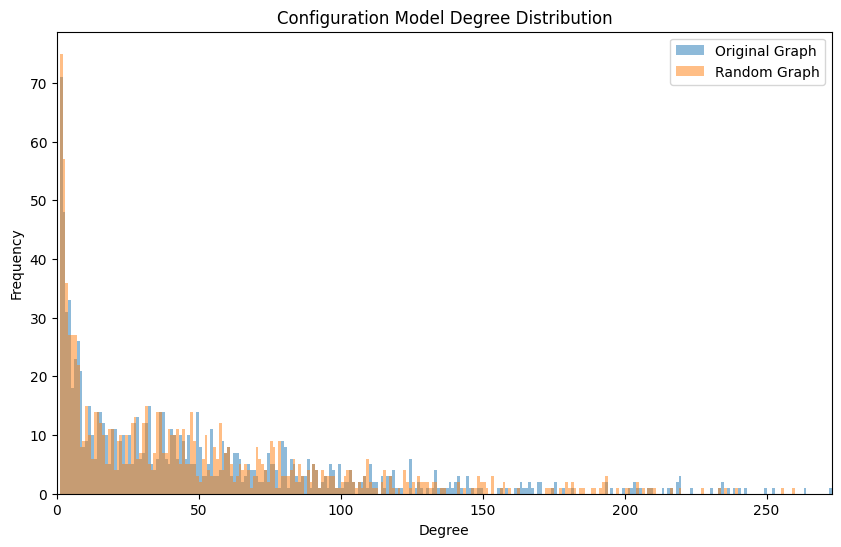

Generating Random graph through Edge Swapping...


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


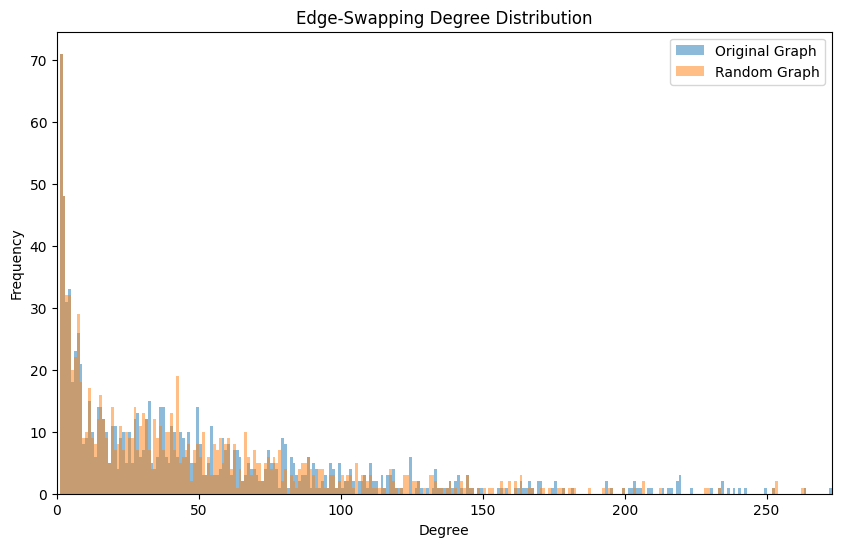

In [ ]:


# Configuration Model: Generate random graph with the same degree sequence
def configuration_model(G, seed=None):
    """
    Generate a random graph using the configuration model,
    preserving the in-degree and out-degree sequences.
    """
    if seed is not None:
        np.random.seed(seed)
    
    in_degrees = [d for _, d in G.in_degree()]
    out_degrees = [d for _, d in G.out_degree()]
    
    # Generate random graph using configuration model
    R = nx.directed_configuration_model(in_degrees, out_degrees, seed=seed)
    
    # Remove parallel edges and self-loops
    R = nx.DiGraph(R)
    R.remove_edges_from(nx.selfloop_edges(R))
    
    return R

# Edge-Swapping Strategy: Generate random graph with the same degree sequence
def edge_swapping(graph, instances=100):
    degree_sequence = [d for _, d in graph.degree()]
    random_graphs = []
    print("Generating Random graph through Edge Swapping...")
    for _ in tqdm(range(instances)):
        random_graph = graph.copy()
        edges = list(random_graph.edges())
        # Edge-swapping process: swap edges randomly while keeping the degree sequence
        for i in range(len(edges) // 2):
            u, v = edges[i]
            w, x = edges[-(i+1)]
            random_graph.remove_edge(u, v)
            random_graph.remove_edge(w, x)
            random_graph.add_edge(u, x)
            random_graph.add_edge(w, v)
        random_graphs.append(random_graph)
    return random_graphs

# Function to plot the degree distribution of the graph
def plot_degree_distribution(graph, random_graphs, title, filename):
    degree_sequence_real = [d for _, d in graph.degree()]
    degree_sequence_random = np.mean([list(dict(g.degree()).values()) for g in random_graphs], axis=0)
    
    # Ensure integer values for degrees
    degree_sequence_random = np.floor(degree_sequence_random).astype(int)
    
    plt.figure(figsize=(10,6))
    plt.hist(degree_sequence_real, bins=range(1, max(degree_sequence_real)+1), alpha=0.5, label='Original Graph', density=False)
    plt.hist(degree_sequence_random, bins=range(1, max(degree_sequence_random)+1), alpha=0.5, label='Random Graph', density=False)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend(loc='upper right')
    max_degree = max(max(degree_sequence_real), max(degree_sequence_random))
    plt.xlim(0, max_degree * 0.5)
    plt.savefig(filename)
    plt.show()

n_instances=100
config_graphs = []
for i in tqdm(range(n_instances)):
    config_graphs.append(configuration_model(G, seed=i))
plot_degree_distribution(G, config_graphs, 'Configuration Model Degree Distribution', 'config_model_degree_dist.png')

# Generate random graphs using Edge-Swapping Strategy
random_graphs_swap = edge_swapping(G, instances=100)
plot_degree_distribution(G, random_graphs_swap, 'Edge-Swapping Degree Distribution', 'edge_swap_degree_dist.png')


MORE DETAILED ANALYSIS

Generating 100 instances using Configuration Model...


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


Generating 100 instances using Edge-Swapping...


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Plotting degree distributions...


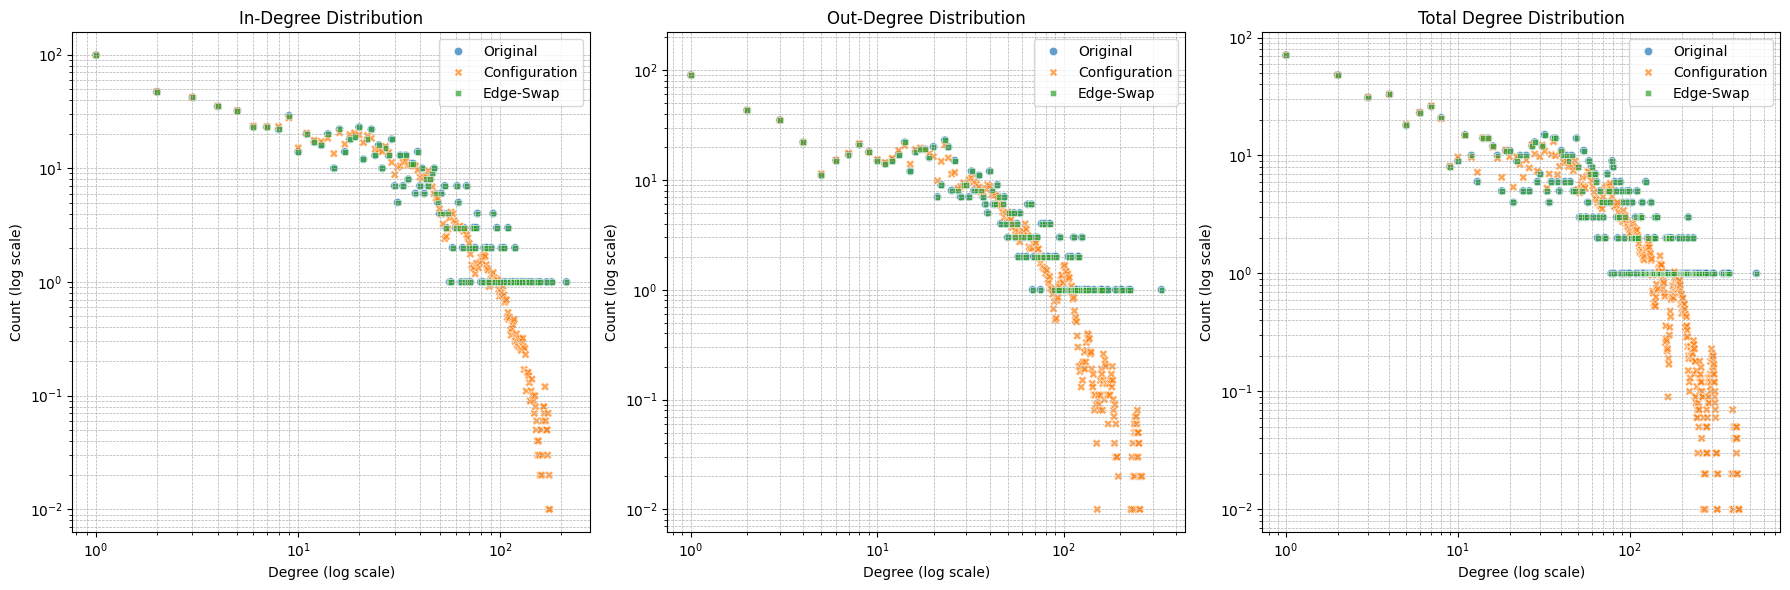

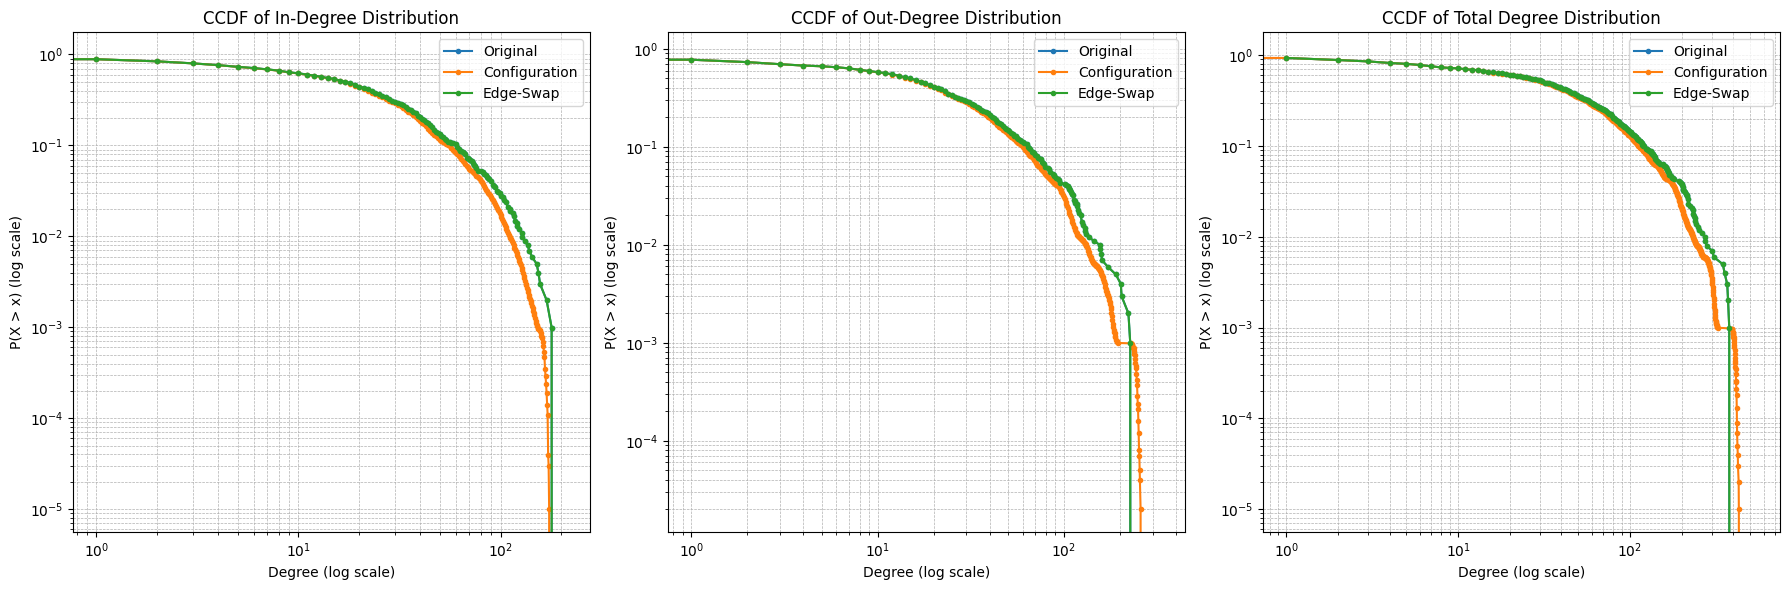

Generating statistics...

Graph Statistics:
          Statistic      Original  Configuration Model  Edge-Swap Model
0             Nodes   1005.000000          1005.000000      1005.000000
1             Edges  25571.000000         23849.750000     25571.000000
2           Density      0.025342             0.023637         0.025342
3   Avg. Clustering      0.399355             0.190093         0.229554
4         SCC Count    203.000000           153.770000       204.430000
5  Largest SCC Size    803.000000           852.230000       801.570000

Execution time: 293.36 seconds


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings

def generate_config_model(G, seed=None):
    """
    Generate a random graph using the configuration model,
    preserving the in-degree and out-degree sequences.
    """
    if seed is not None:
        np.random.seed(seed)
    
    in_degrees = [d for _, d in G.in_degree()]
    out_degrees = [d for _, d in G.out_degree()]
    
    # Generate random graph using configuration model
    R = nx.directed_configuration_model(in_degrees, out_degrees, seed=seed)
    
    # Remove parallel edges and self-loops
    R = nx.DiGraph(R)
    R.remove_edges_from(nx.selfloop_edges(R))
    
    return R

def generate_edge_swap_model(G, n_swaps=None, seed=None):
    """
    Generate a random graph using the edge-swapping strategy,
    preserving the exact in-degree and out-degree of each node.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Create a copy of the original graph
    R = G.copy()
    
    # Set number of swaps if not specified
    if n_swaps is None:
        n_swaps = 2 * R.number_of_edges()
    
    # Perform edge swaps
    try:
        nx.algorithms.swap.directed_edge_swap(
            R, nswap=n_swaps, max_tries=3*n_swaps, seed=seed
        )
    except nx.NetworkXError as e:
        print(f"Warning: Edge swap incomplete - {e}")
    
    return R

def get_degree_distribution(G):
    """
    Get in-degree and out-degree distributions as dictionaries.
    """
    in_degree_dist = Counter(dict(G.in_degree()).values())
    out_degree_dist = Counter(dict(G.out_degree()).values())
    total_degree_dist = Counter(dict(G.degree()).values())
    
    return {
        'in_degree': in_degree_dist,
        'out_degree': out_degree_dist,
        'total_degree': total_degree_dist
    }

def average_degree_distributions(graph_list):
    """
    Average degree distributions across multiple graphs.
    """
    avg_in = Counter()
    avg_out = Counter()
    avg_total = Counter()
    
    # Collect all degrees that appear in any graph
    all_in_degrees = set()
    all_out_degrees = set()
    all_total_degrees = set()
    
    for G in graph_list:
        dist = get_degree_distribution(G)
        
        for degree in dist['in_degree']:
            all_in_degrees.add(degree)
        for degree in dist['out_degree']:
            all_out_degrees.add(degree)
        for degree in dist['total_degree']:
            all_total_degrees.add(degree)
    
    # Initialize counters with zeros for all degrees
    for degree in all_in_degrees:
        avg_in[degree] = 0
    for degree in all_out_degrees:
        avg_out[degree] = 0
    for degree in all_total_degrees:
        avg_total[degree] = 0
    
    # Sum up counts for each degree
    for G in graph_list:
        dist = get_degree_distribution(G)
        
        for degree, count in dist['in_degree'].items():
            avg_in[degree] += count
        for degree, count in dist['out_degree'].items():
            avg_out[degree] += count
        for degree, count in dist['total_degree'].items():
            avg_total[degree] += count
    
    # Divide by number of graphs to get average
    n = len(graph_list)
    for degree in avg_in:
        avg_in[degree] /= n
    for degree in avg_out:
        avg_out[degree] /= n
    for degree in avg_total:
        avg_total[degree] /= n
    
    return {
        'in_degree': avg_in,
        'out_degree': avg_out,
        'total_degree': avg_total
    }

def plot_degree_distributions(original_dist, config_dist, edge_swap_dist):
    """
    Plot degree distributions for original graph and random graph models.
    """
    # Set up figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define degree types and their respective labels
    degree_types = ['in_degree', 'out_degree', 'total_degree']
    titles = ['In-Degree Distribution', 'Out-Degree Distribution', 'Total Degree Distribution']
    
    # For log-log plots
    for i, degree_type in enumerate(degree_types):
        ax = axes[i]
        
        # Convert data to dataframe for easier plotting
        data = []
        
        # Original graph
        for degree, count in sorted(original_dist[degree_type].items()):
            data.append({'Degree': degree, 'Count': count, 'Model': 'Original'})
        
        # Configuration model
        for degree, count in sorted(config_dist[degree_type].items()):
            data.append({'Degree': degree, 'Count': count, 'Model': 'Configuration'})
        
        # Edge-swap model
        for degree, count in sorted(edge_swap_dist[degree_type].items()):
            data.append({'Degree': degree, 'Count': count, 'Model': 'Edge-Swap'})
        
        df = pd.DataFrame(data)
        
        # Log-log plot
        sns.scatterplot(x='Degree', y='Count', hue='Model', style='Model',
                      data=df, ax=ax, alpha=0.7)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Degree (log scale)')
        ax.set_ylabel('Count (log scale)')
        ax.set_title(titles[i])
        ax.legend(title='')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('degree_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Also create a cumulative distribution function plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, degree_type in enumerate(degree_types):
        ax = axes[i]
        
        # Create dataframes for each model
        models = {
            'Original': original_dist[degree_type],
            'Configuration': config_dist[degree_type],
            'Edge-Swap': edge_swap_dist[degree_type]
        }
        
        for model_name, dist in models.items():
            # Sort degrees and create cumulative distribution
            degrees = sorted(dist.keys())
            counts = [dist[d] for d in degrees]
            cum_counts = np.cumsum(counts) / sum(counts)
            
            # Plot CDF
            ax.plot(degrees, 1 - cum_counts, label=model_name, marker='o', markersize=3)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Degree (log scale)')
        ax.set_ylabel('P(X > x) (log scale)')
        ax.set_title(f'CCDF of {titles[i]}')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('degree_ccdf.png', dpi=300, bbox_inches='tight')
    plt.close()

def generate_statistics(original_graph, config_graphs, edge_swap_graphs):
    """
    Generate statistics for the original graph and random models.
    """
    # Original graph statistics
    orig_stats = {
        'nodes': original_graph.number_of_nodes(),
        'edges': original_graph.number_of_edges(),
        'density': nx.density(original_graph),
        'avg_clustering': nx.average_clustering(original_graph.to_undirected()),
        'scc_count': len(list(nx.strongly_connected_components(original_graph))),
        'largest_scc': len(max(nx.strongly_connected_components(original_graph), key=len))
    }
    
    # Function to average statistics across multiple graphs
    def avg_stats(graph_list):
        stats = {
            'nodes': np.mean([G.number_of_nodes() for G in graph_list]),
            'edges': np.mean([G.number_of_edges() for G in graph_list]),
            'density': np.mean([nx.density(G) for G in graph_list]),
            'avg_clustering': np.mean([nx.average_clustering(G.to_undirected()) for G in graph_list]),
            'scc_count': np.mean([len(list(nx.strongly_connected_components(G))) for G in graph_list]),
            'largest_scc': np.mean([len(max(nx.strongly_connected_components(G), key=len)) for G in graph_list])
        }
        return stats
    
    # Calculate statistics for random models
    config_stats = avg_stats(config_graphs)
    edge_swap_stats = avg_stats(edge_swap_graphs)
    
    # Combine into a dataframe
    stat_names = ['Nodes', 'Edges', 'Density', 'Avg. Clustering', 'SCC Count', 'Largest SCC Size']
    stat_values = list(orig_stats.values())
    config_values = list(config_stats.values())
    edge_swap_values = list(edge_swap_stats.values())
    
    df = pd.DataFrame({
        'Statistic': stat_names,
        'Original': stat_values,
        'Configuration Model': config_values,
        'Edge-Swap Model': edge_swap_values
    })
    
    return df

start_time = time.time()
original_graph = nx.read_edgelist('email-Eu-core.txt', create_using=nx.DiGraph())


# Number of random graph instances to generate
n_instances = 100

# Generate random graphs using configuration model
print(f"Generating {n_instances} instances using Configuration Model...")
config_graphs = []
for i in tqdm(range(n_instances)):
    config_graphs.append(generate_config_model(original_graph, seed=i))

# Generate random graphs using edge-swapping
print(f"Generating {n_instances} instances using Edge-Swapping...")
edge_swap_graphs = []
for i in tqdm(range(n_instances)):
    edge_swap_graphs.append(generate_edge_swap_model(original_graph, seed=i))

# Get original degree distribution
original_dist = get_degree_distribution(original_graph)

# Average degree distributions for random models
config_dist = average_degree_distributions(config_graphs)
edge_swap_dist = average_degree_distributions(edge_swap_graphs)

# Plot degree distributions
print("Plotting degree distributions...")
plot_degree_distributions(original_dist, config_dist, edge_swap_dist)

# Generate statistics
print("Generating statistics...")
stats_df = generate_statistics(original_graph, config_graphs, edge_swap_graphs)
print("\nGraph Statistics:")
print(stats_df)

# Save statistics to CSV
stats_df.to_csv('graph_statistics.csv', index=False)

# Report execution time
execution_time = time.time() - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")